# Evaluating analysing sentiment on IMDB

---
## Dataset

The IMDB dataset (Maas et al., 2011) sourced from [ai.stanford.edu]([test](https://ai.stanford.edu/~amaas/data/sentiment/)) contains 50,000 movie reviews for supervised learning. The data is already split into train and test sets, documents are tagged with a class of either positive or negative – but there is the ability to extend this to multiple classes as they are named with a rating on the scale 1-10.

The documents are unprocessed, containing unwanted/misrepresented tokens such as; HTML, hyphenated terms, unwanted characters such as punctuation, currency in multiple formats, URLS, multiple representations of numeric data, unexpanded contractions, stop words, and rare words ("Very rare words might have high IDF scores but might not be truly relevant." (Markovml.com, 2024)).

An exception is given to exclamation marks, as exclamation marks can convey strong sentiment.

The dataset is not case standardised either.

These tokens will be normalised or removed from the documents as they either do not provide semantic meaning or hold multiple representations, allowing for smaller and more meaningful vocabulary.
It is also worth noting that the dataset is balanced providing equal amounts of positive and negative labels.

The task given is to perform sentiment analysis on movie reviews.

### Reading

In [119]:
import os

class DatasetReader:
  # Returns a tuple (X, y)
  @staticmethod
  def load_dataset(dataset):
    X_pos, y_pos = DatasetReader._read_files(dataset, 'pos')
    X_neg, y_neg = DatasetReader._read_files(dataset, 'neg')
    
    X = [*X_pos, *X_neg]
    y = [*y_pos, *y_neg]
  
    return (X, y)
  
  @staticmethod
  def _read_files(dataset, sentiment):    
      if sentiment != 'pos' and sentiment != 'neg':
          raise ValueError("sentiment must be either 'pos' or 'neg")
      
      path = f"{os.getcwd()}\dataset\{dataset}\{sentiment}"
      
      X = []
      y = []
      
      # https://stackoverflow.com/a/18262324
      for file_name in os.listdir(path):
        with open(os.path.join(path, file_name), 'r', encoding='utf-8', errors='ignore') as file:
          content = file.read()
          
          classification = None;
          
          # Convert classification into a binary numeric value. Prevents Invalid dtype: str96 on RNN fit.
          if(sentiment == 'pos'): classification = 1
          elif(sentiment == 'neg'): classification = 0
          
          X.append(content)
          y.append(classification)

      return X,y

In [120]:
X_train, y_train = DatasetReader.load_dataset('train');
X_test, y_test = DatasetReader.load_dataset('test');

### Exploring

In [121]:
from collections import Counter

# Look bias classifications
print("Train:")
print(Counter(y_train).keys());
print(Counter(y_train).values());

print("Test:")
print(Counter(y_test).keys());
print(Counter(y_test).values());

Train:
dict_keys([1, 0])
dict_values([12500, 12500])
Test:
dict_keys([1, 0])
dict_values([12500, 12500])


In [122]:
import regex
import pandas as pd

def count_regex(pattern, doc):
  symbols = regex.findall(pattern, doc)
  
  return len(symbols)

def scan_corpus_for_undesired_tokens(datalist):
  html_tags = 0
  hyphenated_words = 0
  uppercase_chars = 0
  number_of_exclamations = 0
  contains_invalid_char = 0
  currency_symbol_counts = {}
  currency_strings = 0
  contains_url = 0
  
  for doc in datalist:
    # HTML Tag matching: https://github.com/aswintechguy/Data-Science-Concepts/blob/main/NLP/Natural%20Language%20Processing(NLP)%20Concepts%20-%20Hackers%20Realm.ipynb
    html_tags += count_regex(r'<.*?>', doc)
      
    hyphenated_words += count_regex('-+', doc)
    
    uppercase_chars += count_regex('[A-Z]', doc)
    
    number_of_exclamations += count_regex('!+', doc)
    
    currency_strings += count_regex('(?i)(dollar|pound)', doc)
    
    # URL Matching https://github.com/aswintechguy/Data-Science-Concepts/blob/main/NLP/Natural%20Language%20Processing(NLP)%20Concepts%20-%20Hackers%20Realm.ipynb
    contains_url += count_regex(r'https?://\S+|www\.\S+', doc)
    
    # Look forcharacters of not set A-Z a-z 0-9 ! £ $
    contains_invalid_char += count_regex('[^a-zA-Z0-9!£$]', doc)
      
    # https://stackoverflow.com/a/14169836
    symbols = regex.findall('\p{Sc}', doc)
    for symbol in symbols:
      currency_symbol_counts[symbol] = currency_symbol_counts.get(symbol, 0) + 1
      
    
  print(f"HTML Tags: {html_tags}")
  print(f"Likely Hyphenated Words: {hyphenated_words}")
  print(f"Uppercase Chars: {uppercase_chars}")
  print(f"Exclamation Marks: {number_of_exclamations}")
  print(f"Invalid Chars: {contains_invalid_char}")
  
  #https://stackoverflow.com/a/17330263
  for key, value in currency_symbol_counts.items():
    print(f"Currency symbol '{key}' has ({value}) occurences")
    
  print(f"Currency Strings (dollar|pound): {currency_strings}")
  print(f"URLs: {contains_url}")

print('Training Set')
scan_corpus_for_undesired_tokens(X_train)

print('\nTraining Set')
scan_corpus_for_undesired_tokens(X_test)

Training Set
HTML Tags: 101892
Likely Hyphenated Words: 61450
Uppercase Chars: 903115
Exclamation Marks: 19250
Invalid Chars: 7127369
Currency symbol '$' has (782) occurences
Currency symbol '£' has (56) occurences
Currency symbol '¤' has (1) occurences
Currency symbol '₤' has (2) occurences
Currency symbol '¢' has (1) occurences
Currency Strings (dollar|pound): 596
URLs: 105

Training Set
HTML Tags: 100090
Likely Hyphenated Words: 59065
Uppercase Chars: 883809
Exclamation Marks: 19034
Invalid Chars: 6969456
Currency symbol '$' has (835) occurences
Currency symbol '£' has (61) occurences
Currency symbol '¢' has (1) occurences
Currency symbol '¤' has (1) occurences
Currency Strings (dollar|pound): 607
URLs: 103


### Preprocessing

In [123]:
# Tokenizer

# word_tokenize from nltk splits on the backtick ` which is not desired for this domain as it confuses a paticular style of contractions example 'aren`t'.
# To fix this I created a custom tokenizer simply splitting on whitespace.
def tokenize(X):
  return [sentance.split(" ") for sentance in X]

X_train = tokenize(X_train)
X_test = tokenize(X_test)

In [124]:
import inflect
import contractions

inflecter = inflect.engine()

class Normaliser:
  def __init__(self, is_case_standardised, is_alphanumeric_standardised, is_noise_removed, is_contractions_expanded, is_hyphenated_tokens_split, is_extended_substitution, is_urls_removed, is_html_tags_removed):
    self.is_case_standardised = is_case_standardised
    self.is_alphanumeric_standardised = is_alphanumeric_standardised
    self.is_noise_removed = is_noise_removed
    self.is_contractions_expanded = is_contractions_expanded
    self.is_hyphenated_tokens_split = is_hyphenated_tokens_split
    # Methods such as currency substitution (£ -> pound) etc.
    self.is_extended_substitution = is_extended_substitution
    self.is_urls_removed = is_urls_removed
    self.is_html_tags_removed = is_html_tags_removed
  
  def process(self, X):
    # Process each document
    for i in range(len(X)):
      if(self.is_case_standardised): X[i] = self._standardise_case(X[i])
      if(self.is_urls_removed): X[i] = self.remove_urls(X[i])
      if(self.is_html_tags_removed): X[i] = self.remove_html_tags(X[i])
      if(self.is_contractions_expanded): X[i] = self._expand_contractions(X[i])
      if(self.is_alphanumeric_standardised): X[i] = self._standardise_alphanumeric(X[i])
      if(self.is_hyphenated_tokens_split): X[i] = self._split_hyphenated_tokens(X[i])
      if(self.is_extended_substitution): X[i] = self._do_additional_substitution(X[i])
      if(self.is_noise_removed): X[i] = self._remove_noise(X[i])

    return X
  
  def _standardise_case(self, tokens):
    tokens = [token.lower() for token in tokens]
    
    return tokens
  
  def remove_urls(self, tokens):
    # https://github.com/aswintechguy/Data-Science-Concepts/blob/main/NLP/Natural%20Language%20Processing(NLP)%20Concepts%20-%20Hackers%20Realm.ipynb
    tokens = [regex.sub(r'https?://\S+|www\.\S+', '', token) for token in tokens]
    
    return tokens
  
  def remove_html_tags(self, tokens):
    for i in range(len(tokens)):
      # Remove html tags such as <br/> which shows up a lot.
      # https://github.com/aswintechguy/Data-Science-Concepts/blob/main/NLP/Natural%20Language%20Processing(NLP)%20Concepts%20-%20Hackers%20Realm.ipynb
      tokens[i] = regex.sub(r'<.*?>', '', tokens[i])
      
    return tokens
  
  # Uses a third party package in order to generalise terms such as aren't -> are not etc. Again to reduce unique tokens.
  def _expand_contractions(self, tokens):
    new_tokens = []
    
    for token in tokens:
      if("'" in token or "`" in token):
        #contractions.fix do not support ` must convert ` to '. See 8922_4.txt
        token = token.replace("`", "'")
        
        token = contractions.fix(token)
        split = token.split(" ")
        
        new_tokens.extend(split)
      else:
        new_tokens.append(token)
        
    return new_tokens
  
  # Turns numbers into words
  # If an edge case of a number + string it also handles it example "99p" -> "ninety" "nine" "p"
  # Reduces amt of unique tokens
  def _standardise_alphanumeric(self, tokens):
    new_tokens = []
    for token in tokens:
      matches = regex.findall(r'[0-9]+|[^0-9]+', token)
      
      for match in matches:
        if match.isdigit():
          text_digits = inflecter.number_to_words(int(match), wantlist=False, comma="")
          new_tokens.extend(text_digits.split(" "))
        else:
          new_tokens.append(match)
          
    return new_tokens
  
  # Split hyphenated tokens into two tokens to reduce number of unique tokens.
  def _split_hyphenated_tokens(self, tokens):
    new_tokens = []
    for token in tokens:
      if regex.match("[a-zA-Z]+-[a-zA-Z]+", token):
        split = token.split("-")
        new_tokens.extend(split)
      else:
        new_tokens.append(token)
    return new_tokens
  
  # Only keeps characters of A-Z a-z 0-9 ! to further reduce vocabulary size and focus on more meaningful vocabulary.
  def _remove_noise(self, tokens):
    for i in range(len(tokens)):
      tokens[i] = regex.sub("[^a-zA-Z0-9!]", "", tokens[i])
      
    # remove empty items
    return [token for token in tokens if token]
  
  # run after standardise_alphanumeric as "£100" -> would be "£", "one"...
  def _do_additional_substitution(self, tokens):
    for i in range(len(tokens)):
      # Convert £ and $ into words - £ and $ were used almost exclusively in the dataset.
      # Currency is often used in reviews to discuss movie budget.
      if '£' in tokens[i]:
        tokens[i] = tokens[i].replace('£', "pound");
      elif '$' in tokens[i]:
        tokens[i] = tokens[i].replace('$', "dollar");
      
    return tokens

IMDB_standard_normaliser = Normaliser(
  is_case_standardised=True,
  is_alphanumeric_standardised=True,
  is_noise_removed=True,
  is_contractions_expanded=True,
  is_hyphenated_tokens_split = True,
  is_extended_substitution = True,
  is_urls_removed = True,
  is_html_tags_removed = True
)

X_train = IMDB_standard_normaliser.process(X_train)
X_test = IMDB_standard_normaliser.process(X_test)

In [125]:
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords 

# https://stackoverflow.com/a/57732953
# https://www.markovml.com/blog/tf-idf
# Rare Words: Very rare words might have high IDF scores but might not be truly relevant.
def remove_stop_and_rare_words(X, min_occurrences):
    token_occurrences = {}
  
    for item in X:
      for token in item:
        token_occurrences[token] = token_occurrences.get(token, 0) + 1
    
    remove_set = set(stopwords.words('english'))
    
    for key, value in token_occurrences.items():
      if value < min_occurrences:
        remove_set.add(key)
    
    for i in range(len(X)):
      X[i] = [token for token in X[i] if token not in remove_set]

    return X
  
X_train = remove_stop_and_rare_words(X_train, min_occurrences=3)
X_test = remove_stop_and_rare_words(X_test, min_occurrences=3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Representation Learning

Representation learning is a name given to the concept of converting your input data into a format that can be understood by machine learning algorithms. This is usually in the form of numeric vectors.
| Representation Learning Method | Machine Learning Algorithm    |
|--------------------------------|-------------------------------|
| TF-IDF                         | Naive Bayes                  |
| (token indicies) + GloVe       | Recurrent Neural Network     |


### TF-IDF

TF-IDF (Term Frequency – Inverse Document Frequency) is a measure of how important a (term | word) is to a document relative to the entire corpus. 

A pseudocode representation of this algorithm looks like this: <br/>
```TF-IDF = (count(term) in document / count(all_terms)) * log(len(corpus) / len(for document in corpus where term in document))```

I derived this pseudocode from ritvikmath, 2020's TF-IDF explanation.

In [126]:
# https://www.kdnuggets.com/2022/09/convert-text-documents-tfidf-matrix-tfidfvectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer # pip install scikit-learn not sklearn...

# No need to use any preprocessor as input was previously preprocessed in this report.
vectorizer = TfidfVectorizer(lowercase=False, preprocessor=None)

# TF-IDF Matrix
X_train_TF_IDF = vectorizer.fit_transform([' '.join(tokens) for tokens in X_train]);
# https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# Transform the test data using TF-IDF but remain the shape of X_train_TF_IDF.
X_test_TF_IDF = vectorizer.transform([' '.join(tokens) for tokens in X_test]);

### Token Indicies + GloVe

GloVe is an algorithm which creates a numeric vector representation of words and their context. A competing algorithm is Word2Vec, both algorithms create a continuous dense numeric representation of a word, meaning that similar terms will be close in vector value. GloVe is advantageous as it uses global world co-occurrence, this allows the understanding of relationships between terms even if the terms don't frequently appear within the same local context.

The resulting Glove Embedding Matrix is fed into a RNN in the format of weights. A word index is created and then documents are represented as a list of numeric indexes for the RNN input.

In [127]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000  # Maximum vocabulary size
max_length = 50

# https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n
X_train_cleaned = [' '.join(tokens) for tokens in X_train];
X_test_cleaned = [' '.join(tokens) for tokens in X_test];

tokenizer = Tokenizer(oov_token="<OOV>", num_words=max_words)
tokenizer.fit_on_texts(X_train_cleaned)

X_train_seq_padded = tokenizer.texts_to_sequences(X_train_cleaned)
X_train_seq_padded = pad_sequences(X_train_seq_padded, maxlen=max_length)

X_test_seq_padded = tokenizer.texts_to_sequences(X_test_cleaned)
X_test_seq_padded = pad_sequences(X_test_seq_padded, maxlen=max_length)

X_train_seq_padded = np.array(X_train_seq_padded)
X_test_seq_padded = np.array(X_test_seq_padded)

In [128]:
# https://www.kaggle.com/code/francoisdubois/build-a-word-embedding-with-glove-matrix

embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [129]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Algorithims

### Naive Bayes

Multinomial Naive Bayes (MNB or NB) is a classification algorithm. It works by calculating the likelihood of each TF-IDF occurring for each classification (positive | negative) then multiplying each likelihood to form the product for that document. The product is calculated for both positive and negative classifications, the highest product or probability value is chosen as the classification. 

```likelihood(TScore = TF-IDF Score, y = classification) = number of times TScore occurs in corpus[y] / total number of all TF-IDF scores in corupus[y]```

One of the major issues with Naive Bayes is that it does not consider the order of terms important and only relies on the probability of a term appearing in the corpus. 



In [130]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X_train_TF_IDF, y_train)

MultinomialNB()

### Recurrent Neural Network

Recurrent Neural Networks (RNN) are used for many applications, I use it as a binary classifier. RNN was chosen for it’s abilities in handling sequential data, this is great for text. RNN's can retain information from previous inputs, this is not a feature of traditional neural networks.

This report's RNN is a modification of the RNN from Abdelrahman Mohamed, 2023 article on sentiment analysis. The embedding layer was modified to take in a GloVe embedding matrix and the output layer was changed to work with binary classification.

This RNN consists of the following layers:
* Embedding Layer - In this layer the GloVe embedding matrix made earlier is provided. 
  
* LSTM Layer - Long short-term memory known as LSTM is what makes the neural network an RNN. This layer allows the network to remember previous inputs, the size of the memory is defined by the number of neurons, each neuron learning to capture patterns or features over time. A larger the number of neurons will increase the model's performance but results in higher chronological or computational requirements.
  
* Dropout - Dropout layers help reduce model overfitting. They do this by randomly selecting a fraction of neurons from the previous LSTM layer and then removing them or setting them as zero. 

* Dense Layer - This layer maps all the neurons from the previous layer to an output format specified by the activation format. This output representation is given to the next layer. Relu is useful as it sets neurons with inputs of negative numerical values to 0, this basically removes neurons which are not contributing to the networks performance. Neurons with positive numerical value are kept, ready to be provided to the next layer  (GeeksforGeeks, 2024). The sigmoid activation function is used as an output layer for final binary classification, it outputs a number between 0 and 1. With 0.5 being the margin of classification ```< 0.5 = negative``` ```> 0.5 = positive``` (Ali, M., 2023).

#### Compilation

The Binary Cross entropy loss function is used as the report is focussing on binary classification (using the sigmoid output from the dense layer). The aim of the loss function is to reduce the gap between the predicted output probability and the actual output.

To assist in reducing the loss, Adam (optimisation method) gently configures the parameters based on the loss gradient, it eventually trains a more accurate set of weights (Vishwakarma, 2023).


In [131]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_model():
    model = Sequential()

    model.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[embedding_matrix]))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam')

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Apply early stopping

    return model, early_stopping

In [132]:
model, early_stopping = build_model()
model.summary()

C:\Users\adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [133]:
batch_size = 250 # The number of documents to process before optimising the weights.
history = model.fit(X_train_seq_padded,np.array(y_train),epochs=15,batch_size=batch_size,callbacks=[early_stopping])

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.6257
Epoch 2/15
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.4788

C:\Users\adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.4162
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.3200
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.2725
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.2257
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.1872
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.1404
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.1109
Epoch 9/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0858
Epoch 10/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0807
Epoch 11/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0582
Epoch 12/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0600
Epoch 13/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0450
Epoch 14/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0369
Epoch 15/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0252


The algorithm uses the full 15 epochs even with the early stopping method suggesting that this RNN could be more accurate with increased epochs.

## Evaluation

In [134]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, fbeta_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


y_pred_nb = nb_model.predict(X_test_TF_IDF)
y_pred_rnn = [item.round() for item in model.predict(np.asarray(X_test_seq_padded))]

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step


### Accuracy

C:\Users\adam\AppData\Local\Temp\ipykernel_4796\1410728156.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=bar_chart_df, palette=['red', 'green'])


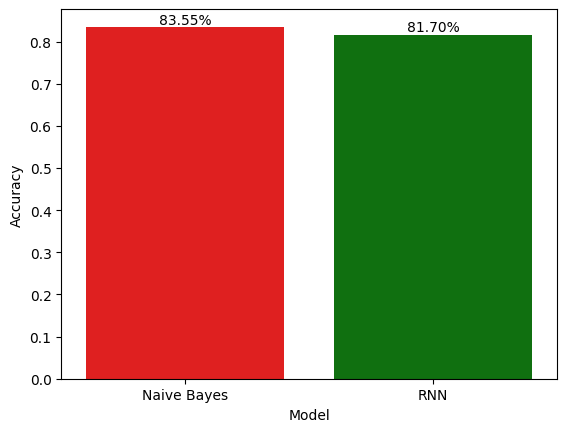

In [135]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
rnn_accuracy = accuracy_score(y_test, y_pred_rnn)

bar_chart_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'RNN'],
    'Accuracy': [nb_accuracy, rnn_accuracy]
})

sns.barplot(x='Model', y='Accuracy', data=bar_chart_df, palette=['red', 'green'])

for index, row in bar_chart_df.iterrows():
    plt.text(index, row['Accuracy'], f"{row['Accuracy'] * 100:.2f}%", ha='center', va='bottom', fontsize=10, color='black')
    
plt.show()


The NB model is slightly more accurate at 83.55% compared to the RNN 81.70%. Accuracy does not evaluate the correctness of individual classes just the overall correctness. Other metrics are used below to further evaluate.

# F1

C:\Users\adam\AppData\Local\Temp\ipykernel_4796\638027376.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1', data=bar_chart_df, palette=['red', 'green'])


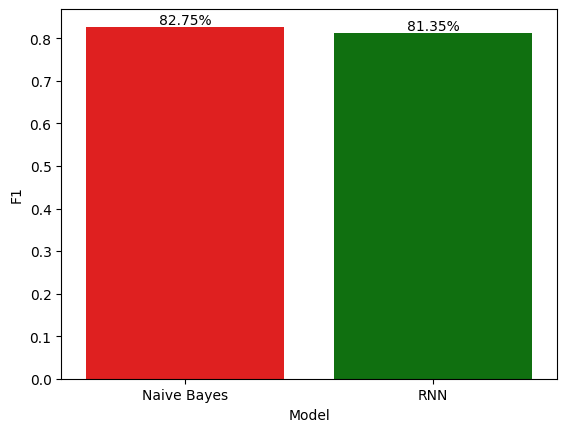

Naive Bayes
              precision    recall  f1-score   support

           0       0.81      0.88      0.84     12500
           1       0.87      0.79      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

RNN
              precision    recall  f1-score   support

           0       0.81      0.84      0.82     12500
           1       0.83      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



In [136]:
# https://machinelearningmastery.com/fbeta-measure-for-machine-learning/

nb_fbeta = fbeta_score(y_test, y_pred_nb, beta=1)
rnn_fbeta = fbeta_score(y_test, y_pred_rnn, beta=1)

bar_chart_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'RNN'],
    'F1': [nb_fbeta, rnn_fbeta]
})

sns.barplot(x='Model', y='F1', data=bar_chart_df, palette=['red', 'green'])

for index, row in bar_chart_df.iterrows():
    plt.text(index, row['F1'], f"{row['F1'] * 100:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

plt.show()

nb_cr = classification_report(y_test, y_pred_nb)
print("Naive Bayes")
print(nb_cr)

print("RNN")
rnn_cr = classification_report(y_test, y_pred_rnn)
print(rnn_cr)

The F1 score is a combination of the precision and recall metrics. It grants a good understanding of the performance of the model across all classes.

Both NB and RNN perform almost (rounding) equally in correctly identifying negatives (Precision class 0). But NB is better at correctly predicting positives (Precision class 1). However, NB is 1% more likely to predict positives as negative (Recall class 1). Again RNN underperforms as it is 4% more likely to predict negatives as positive (Recall class 0).  

The F1 score indicates that NB is better at predicting negatives by 2% and 1% better at predicting positives than the RNN. The RNN could improve its scores by fine-tuning parameters.


### Confusion Matrix

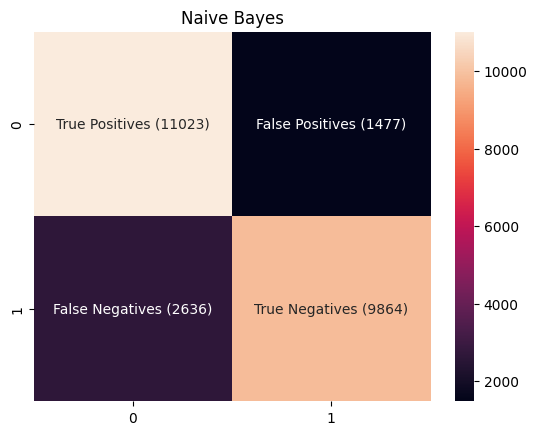

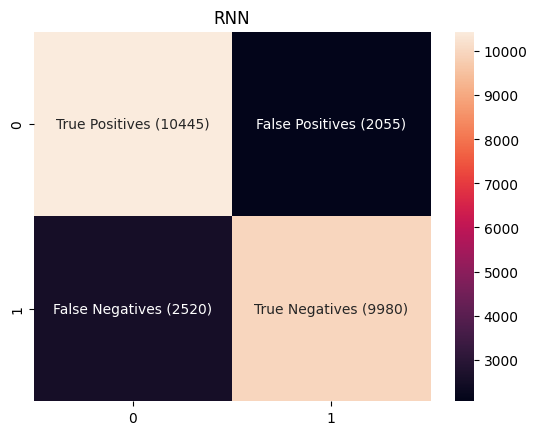

In [137]:
# Reference: An adaption of my person Big Data Submission (Govier, A. 2022).

def displayConfusionMatrix(y_pred, title):
  cfMatrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cfMatrix, annot = genLabels(cfMatrix), fmt='')
  plt.title(title)
  plt.show()
  
# Took from my Big Data Submission
def genLabels(matrix):
    # Get values for True Positive, False Positive, etc.
    tp, fp, fn, tn = matrix[0][0], matrix[0][1], matrix[1][0], matrix[1][1]
    
    # Create positives labels with counts.
    positives = []
    positives.append(f"True Positives ({tp})")
    positives.append(f"False Positives ({fp})")
    
    # Create negative labels with counts.
    negatives = []
    negatives.append(f"False Negatives ({fn})")
    negatives.append(f"True Negatives ({tn})")
    
    # Return a two dimensional array
    return [positives, negatives]

displayConfusionMatrix(y_pred_nb, 'Naive Bayes')
displayConfusionMatrix(y_pred_rnn, 'RNN')

The confusion matrix further explains the above (F1) conclusions with concrete figures.

### RNN vs NB Conclusion

Using non-fine-tuned parameters, NB outperforms the RNN by 2% according to the F1 score. I was surprised at this as the RNN has an understanding of context. Without fine-tuning. I would recommend using NB for predicting movie reviews.

## ULMFiT

Universal Language Model Fine-tuning (ULMFiT) introduced by Howard, J. and Ruder, S., 2018's paper is an algorithm that creates domain-specific classification models with the knowledge of a specified pretrained language model (LM). UMLFiT significantly reduces the computational, chronological, and dataset row size requirements to train powerful models comparable to state of the art solutions.

UMLFiT for sentiment analysis is a 3-stage process:

1. Choose a pretrained LM - the paper specifies the performance of UMLFiT is greatly dependent on the initial pretrained model. AWD_LTSM trained on wikitext-103 is a good match.
   
2. Then the pretrained LM’S parameters are adjusted to a specific dataset.
   
3. A classifier is trained using the fine-tuned LM.
   
Overfitting to the domain-model i.e, forgetting the expertise of the pretrained language model is an issue. 

Preventative techniques:

1. Discriminative Fine-Tuning allows for a different learning rate to be specified at each layer of the language model. This gives greater control of how much the model should fit to the new domain.
   
2. Slanted Triangle Learning Rates effectively place learning rates on a gradient, at the beginning a high learning rate is provided to eagerly bind the model to the domain, this learning rate is then reduced over time in order to retain generalised knowledge from the pretrained LM.
   
3. Gradual Unfreezing trains layers gradually. The last layer contains the least generalised knowledge from the pretrained LM, so as the model is unfrozen it becomes more and more generalised. Training it all at once could result in the last layer being dominant in the results.
   
I have included some of the paper’s hyperparameters in my recreation, I haven't used some parameters as it throws an error stating invalid shapes. LSTM_AWD provided by FASTAI has different parameters than used in the original paper and changing these would require retraining the LM. 

The epochs used to fine-tune is not stated, however, for the dataset "TREC-6" 15 epochs are used for LM fine-tuning and they stated 50 epochs is a good default for training the classifiers. 


In [ ]:
# This Python recreation has been made using the [documentation provided by FASTAI](https://docs.fast.ai/examples/ulmfit.html) (fastai, 2024) 
# and guidance provided by [Let’s learn about Universal Language Model Fine-tuning, ULMFiT](https://medium.com/@ashleyha/lets-learn-about-universal-language-model-fine-tuning-ulmfit-through-practical-applications-fea0aed2cf96) (Ha, 2023).

from fastai.text.models.awdlstm import awd_lstm_lm_config
from fastai.text.models.awdlstm import awd_lstm_clas_config
from fastai.text.all import *

config_lm = awd_lstm_lm_config.copy()

# https://docs.fast.ai/text.models.awdlstm.html
# config_lm['emb_sz'] = 400 # "embedding size of 400"
# config_lm['n_layers'] = 3 # "3 layers"
# config_lm['n_hid'] = 1150 # "1150 hidden activations per layer"
config_lm['hidden_p'] = 0.3 # "03 to RNN layers"
config_lm['input_p'] = 0.4 # "04 to input embed ding layer"
config_lm['embed_p'] = 0.05 # "005 to embedding layer"
config_lm['weight_p'] = 0.5 # "weight dropout of 05 to the RNN hidden-to-hidden matrix"
# config_lm['bidir'] = False

bptt = 70 # "BPTT batch size of 70"

config_clf = awd_lstm_clas_config.copy()
# config_clf['n_hid'] = 50

epochs_lm = 15
epochs_clf = 50
bs = 64 # "We use a batch size of 64"

# a base learning rate of 0004 and 001 for fine tuning the LM and the classifier respectively
base_learning_rate_lm = 0.004
base_learning_rate_clf = 0.01


metrics = [accuracy, FBeta(beta=1, average='weighted')]

# https://docs.fast.ai/optimizer.html#adam-1
# mom = beta1
opt_func = partial(Adam, mom=0.7) # "We use Adam with 1 = 07 instead of the default 1 = 09 and 2 = 099"


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

df = pd.DataFrame({'text': X_train_cleaned, 'label': y_train})

dls_lm = TextDataLoaders.from_df(df, text_col='text', label_col='label', is_lm=True, bs=bs, bptt=bptt)

learn = language_model_learner(dls_lm, AWD_LSTM, config=config_lm, opt_func=opt_func, metrics=metrics)
learn.fit_one_cycle(epochs_lm, base_learning_rate_lm)

learn.save_encoder('ft_enc')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


C:\Users\adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\text\learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,8.659939,7.985004,0.035801,0.018874,32:41
1,8.071221,7.624629,0.058199,0.029472,29:55
2,7.829275,7.459539,0.067548,0.038311,29:52
3,7.691077,7.373174,0.073238,0.042618,29:51
4,7.596717,7.329498,0.075034,0.045612,30:23
5,7.531146,7.300754,0.077077,0.047575,30:05
6,7.485858,7.276565,0.078654,0.049895,31:19
7,7.446675,7.263288,0.079058,0.050351,31:38
8,7.399400,7.249152,0.080122,0.050223,31:29
9,7.371675,7.240411,0.080520,0.051629,30:09


In [ ]:
dls_clas = TextDataLoaders.from_df(df, text_col='text', label_col='label', vocab=dls_lm.vocab, bs=bs)

learn = text_classifier_learner(dls_clas, AWD_LSTM, metrics=metrics, opt_func=opt_func, config=config_clf)
learn.load_encoder('ft_enc')

# Gradual Unfreezing: it was not clear the exact parameters used for this step nor the number of freezes so I have frozen based off the number of 
# layers specified for the LM by the paper and fractions of the base_learning_rate_clf also provided by the paper. 

# Equal epochs for each layer (min: 1) or 3 total.
local_epoch = max(1, round(epochs_clf / 3));

learn.freeze_to(-1) # Freeze every layer except the final one
learn.fit_one_cycle(local_epoch, base_learning_rate_clf) # inital training rate

learn.freeze_to(-2)  # Freeze every layer except the final two
learn.fit_one_cycle(local_epoch, base_learning_rate_clf / 2)  # lower training weight 1/2

learn.unfreeze()  # Train classifier on all layers
learn.fit_one_cycle(local_epoch, base_learning_rate_clf / 4)  # # lower train weight again 1/4 

learn.save('ft_clas')

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


C:\Users\adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\text\learner.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.406747,0.347274,0.852800,0.852774,06:47
1,0.394396,0.349081,0.851200,0.851174,07:22
2,0.389949,0.344464,0.852800,0.852774,07:28
3,0.393720,0.335369,0.857800,0.857740,06:56
4,0.379765,0.336325,0.856800,0.856758,07:01
5,0.382303,0.331561,0.858600,0.858555,07:00
6,0.364545,0.325101,0.862800,0.862779,07:05
7,0.374215,0.329695,0.862200,0.862115,06:51
8,0.370566,0.320826,0.864200,0.864212,06:43
9,0.352457,0.319940,0.862400,0.862295,06:49


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.334219,0.318583,0.864000,0.864003,09:05
1,0.336308,0.301795,0.871600,0.871552,08:50
2,0.328621,0.301921,0.874000,0.873992,08:36
3,0.302860,0.304701,0.872600,0.872344,08:43
4,0.279663,0.348596,0.850400,0.849194,08:49
5,0.253639,0.290359,0.886000,0.885919,08:43
6,0.240541,0.279920,0.887200,0.887204,08:49
7,0.219664,0.295784,0.887200,0.887183,08:38
8,0.184073,0.304858,0.882800,0.882758,08:35
9,0.161976,0.315565,0.887800,0.887805,08:00


epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.096558,0.374330,0.890600,0.890587,16:58
1,0.140532,0.429773,0.873000,0.872353,16:59
2,0.185240,0.316086,0.895000,0.894995,17:02
3,0.175804,0.290353,0.897200,0.897195,17:04
4,0.134829,0.379057,0.885200,0.884670,17:08
5,0.087795,0.316567,0.897000,0.896903,17:30
6,0.069313,0.381152,0.880800,0.880482,17:17
7,0.046871,0.438756,0.891600,0.891376,17:25
8,0.030898,0.524065,0.885600,0.885310,17:34
9,0.021076,0.427003,0.896800,0.896758,17:33


Path('models/ft_clas.pth')

In [99]:
df_test = pd.DataFrame({'text': X_test_cleaned, 'label': y_test})

# https://stackoverflow.com/questions/63066820/how-to-get-predictions-on-dataframe-in-fastai
test_dl = learn.dls.test_dl(df_test, with_labels=True)

# https://docs.fast.ai/learner.html#learner.validate validate can take in a data loader.
results = learn.validate(dl=test_dl)

In [100]:
print(results)

[0.7735698223114014, 0.8663600087165833, 0.8660015597466575]


C:\Users\adam\AppData\Local\Temp\ipykernel_4796\4050234732.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=bar_chart_df, palette=['red', 'green', 'blue'])


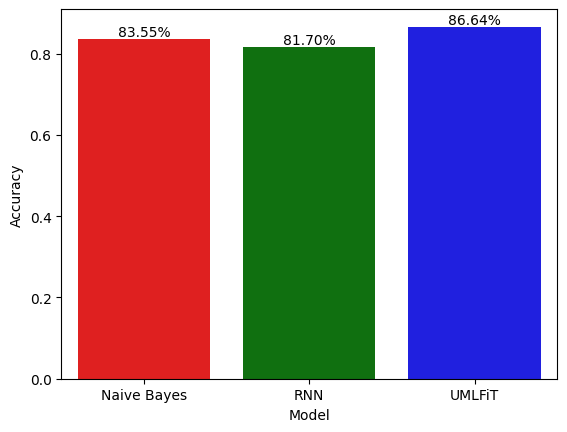

In [138]:
bar_chart_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'RNN', 'UMLFiT'],
    'Accuracy': [nb_accuracy, rnn_accuracy, results[1]]
})

sns.barplot(x='Model', y='Accuracy', data=bar_chart_df, palette=['red', 'green', 'blue'])

for index, row in bar_chart_df.iterrows():
    plt.text(index, row['Accuracy'], f"{row['Accuracy'] * 100:.2f}%", ha='center', va='bottom', fontsize=10, color='black')
    
plt.show()

C:\Users\adam\AppData\Local\Temp\ipykernel_4796\1903778978.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='F1', data=bar_chart_df, palette=['red', 'green', 'blue'])


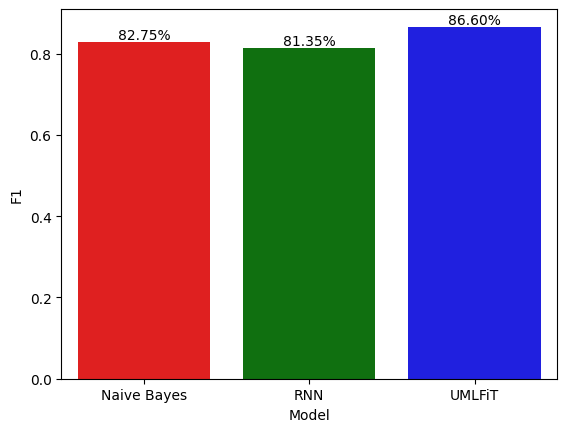

In [139]:
bar_chart_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'RNN', 'UMLFiT'],
    'F1': [nb_fbeta, rnn_fbeta, results[2]]
})

sns.barplot(x='Model', y='F1', data=bar_chart_df, palette=['red', 'green', 'blue'])

for index, row in bar_chart_df.iterrows():
    plt.text(index, row['F1'], f"{row['F1'] * 100:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

plt.show()

After 18h of training, a  stronger performing model than the previous 2 evaluated models was produced. UMLFiT has an accuracy 95.4%, considerably higher than this recreation (paperswithcode.com, n.d.).

Reasons:
•	The used pretrained AWD_LTSM was trained by FASTAI, it had different parameters and a different shape.

•	Input data is different due to different preprocessing.

•	Epoch numbers will not match, they were an educated guess.

•	It is unclear which layers were frozen, and amount to decrease the training rate each time.


Error rates and loss as the used metrics, unfortunately, I did not realise we had to use the same metrics until after the 18h train. I don’t have the time to retrain.


## References

DEV Community. (2021). Tokenization and Sequencing in TensorFlow. [online] Available at: https://dev.to/balapriya/tokenization-and-sequencing-in-tensorflow-3p0n.

Maas, A.L., Daly, R.E., Pham, P.T., Huang, D., Ng, A.Y. and Potts, C. (2011) 'Learning word vectors for sentiment analysis', Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies, Portland, Oregon, USA, June. Association for Computational Linguistics, pp. 142–150. Available at: http://www.aclweb.org/anthology/P11-1015 (Accessed: 27 November 24).

Markovml.com. (2024). TF-IDF Explained: Unlock Keyword Analysis for Your Text Data. [online] Available at: https://www.markovml.com/blog/tf-idf.

ritvikmath (2020). TFIDF : Data Science Concepts. [online] YouTube. Available at: https://youtu.be/OymqCnh-APA [Accessed 27 Nov. 2024].

Mohamed, A. (2023). Sentiment Analysis on IMDB Movie Reviews: A Beginner’s Guide. [online] Medium. Available at: https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56 [Accessed 27 Nov. 2024].

GeeksforGeeks (2024). ReLU Activation Function in Deep Learning. [online] GeeksforGeeks. Available at: https://www.geeksforgeeks.org/relu-activation-function-in-deep-learning [Accessed 28 Nov. 2024].

Ali, M. (2023). Introduction to Activation Functions in Neural Networks. [online] Datacamp.com. Available at: https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks [Accessed 28 Nov. 2024].

Vishwakarma, N. (2023). What is Adam Optimizer? [online] Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/ [Accessed 28 Nov. 2024].

Howard, J. and Ruder, S., 2018. Universal language model fine-tuning for text classification. arXiv preprint arXiv:1801.06146.

fastai. (2024). ULMFiT – fastai. [online] Available at: https://docs.fast.ai/examples/ulmfit.html.

Ha, A. (2023). Let’s learn about Universal Language Model Fine-tuning, ULMFiT. [online] Medium. Available at: https://medium.com/@ashleyha/lets-learn-about-universal-language-model-fine-tuning-ulmfit-through-practical-applications-fea0aed2cf96.

paperswithcode.com. (n.d.). Papers with Code - IMDb Benchmark (Sentiment Analysis). [online] Available at: https://paperswithcode.com/sota/sentiment-analysis-on-imdb.

Govier, A. (2023) CM3111 - Coursework.

francoisdubois (2019). Build a word embedding with GloVe matrix. [online] Kaggle.com. Available at: https://www.kaggle.com/code/francoisdubois/build-a-word-embedding-with-glove-matrix [Accessed 4 Dec. 2024].

aswintechguy (2022). Data-Science-Concepts/NLP/Natural Language Processing(NLP) Concepts - Hackers Realm.ipynb at main · aswintechguy/Data-Science-Concepts. [online] GitHub. Available at: https://github.com/aswintechguy/Data-Science-Concepts/blob/main/NLP/Natural%20Language%20Processing(NLP)%20Concepts%20-%20Hackers%20Realm.ipynb [Accessed 4 Dec. 2024].

‌